# Patski cell-cycle Classification
## Introduction

Access to well-structured data allows for diverse approaches to analysis and exploration. These can range from visualizations and statistical computations to clustering and classification. For example, the HiStrux package expects a method to classify cells into specific interphase stages. This process is crucial not only for generating insights and visualizations but also as an input for the reConstruct module within the HiStrux package.

The adopted methodology assigns probabilities to cells, indicating their likelihood of belonging to one of the interphase stages—G1, S, or G2M. This notebook details the reasoning behind the approach and presents the final model CycleSort used to classify cells into their respective stages.


# Data
The data used for this analysis originates from the transformed Patski dataset, processed through the eXtract module of the HiStrux package. These transformed data, specifically the feature vectors for each cell, will serve as the foundation for our work.

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


pd.set_option('display.max_columns', None)
folder_path = 'patski'
patski_df = pd.DataFrame()

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        new_df = pd.read_csv(os.path.join(folder_path, file_name), sep=';')

        if 'S_' in file_name:
            new_df['Stage'] = 'S'
        elif 'G1_' in file_name:
            new_df['Stage'] = 'G1'
        elif 'G2M_' in file_name:
            new_df['Stage'] = 'G2M'
        else:
            new_df['Stage'] = 'Unknown'
        patski_df = pd.concat([patski_df, new_df], ignore_index=True)

patski_df = patski_df.drop_duplicates('cell_id')
print(f"Unique count: {len(patski_df['cell_id'].unique())}")
patski_df.head(4)

Unique count: 855


,cell_id,f_trans,mean_contact_length,std_contact_length,AA,BB,AB,mcm_near_ratio,mcm_mid_ratio,mcm_far_ratio,pofs_slope,pofs_intercept,pofs_r_value,pofs_p_value,pofs_std_err,p_of_s,chr1_value,chr10_value,chr11_value,chr12_value,chr13_value,chr14_value,chr15_value,chr16_value,chr17_value,chr18_value,chr19_value,chr2_value,chr3_value,chr4_value,chr5_value,chr6_value,chr7_value,chr8_value,chr9_value,chrX_value,tad_n_tads_mean,tad_mean_bin_size,tad_density_mean,Stage
0,SCG0093_AAATGCCTCCAAGTGT-1,0.185870,117.975543,46.314073,0.328438,0.662216,0.009346,0.168895,0.145617,0.685488,-1.196682,-1.556172,-0.988059,1.803055e-23,0.035913,[0.01963785 0.01673661 0.01234756 0.0081673 0...,0.689272,0.659823,0.721883,0.518605,0.615099,0.687693,0.741376,0.612372,0.649406,0.657938,0.542563,0.717326,0.600000,0.516046,0.616260,0.624921,0.578920,0.633042,0.620895,0.609557,43.574317,14.509880,0.068919,G1
1,SCG0092_GCTTAGTAGCACTAGT-1,0.173957,118.639030,45.179687,0.372742,0.613711,0.013547,0.160528,0.151494,0.687978,-0.889068,-1.813832,-0.961694,1.053355e-16,0.048771,[0.01651038 0.01407162 0.01038847 0.00689616 0...,0.565201,0.586538,0.609821,0.417474,0.586671,0.599618,0.566270,0.528812,0.629022,0.535549,0.657570,0.640621,0.635070,0.494498,0.630476,0.584395,0.647023,0.560984,0.560984,0.495634,62.563135,10.015214,0.099848,G1
2,SCG0090_ATGGCTTAGCTTTGGG-1,0.099163,114.434310,46.988139,0.358569,0.638179,0.003251,0.242268,0.139175,0.618557,-0.992160,-1.999797,-0.934379,1.282219e-13,0.072806,[0.01223738 0.01023172 0.00728869 0.00462264 0...,0.613142,0.560263,0.656242,0.499917,0.621756,0.497930,0.626597,0.546453,0.628675,0.572334,0.669587,0.512756,0.554021,0.510208,0.619267,0.589708,0.474595,0.638124,0.576320,0.487091,63.337945,9.961651,0.100385,G1
3,SCG0090_GGGTTACGTGTTAAAC-1,0.142428,116.813702,46.754896,0.377715,0.618080,0.004205,0.216095,0.147541,0.636364,-0.987331,-2.013599,-0.947223,7.315550e-15,0.064307,[0.01097093 0.00927024 0.00671949 0.00431506 0...,0.528900,0.523241,0.515803,0.411663,0.538061,0.443260,0.515252,0.453528,0.567827,0.494401,0.547101,0.494728,0.572709,0.396968,0.593243,0.467800,0.513226,0.571398,0.508605,0.431211,62.301570,10.066113,0.099343,G1


# Initial Analysis and Basic Model



## Clustering Analysis
For the initial analysis, standard clustering was applied by assigning labels based on the mode (dominant value) within each cluster. This approach allows for visualizing the data and gaining intuition about its structure.

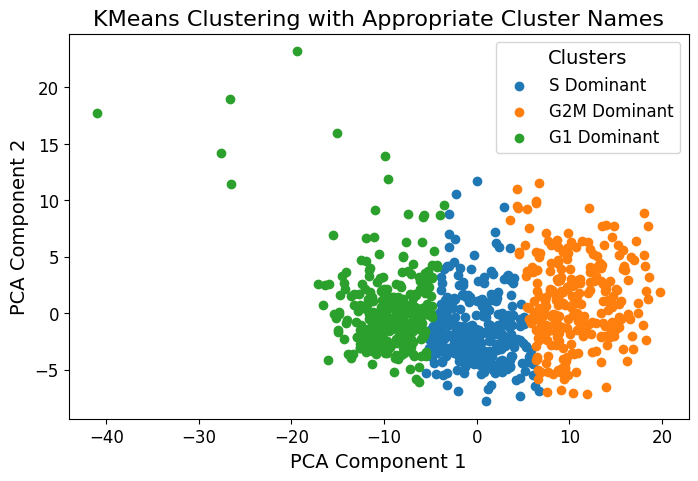

In [ ]:
df = patski_df.copy()
df = df.dropna()
df = df.drop(columns=["cell_id", "p_of_s"])

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df.drop(columns=['Stage']))

cluster_names = {}
for cluster_id in df['Cluster'].unique():
    dominant_stage = df[df['Cluster'] == cluster_id]['Stage'].mode()[0]
    cluster_names[cluster_id] = f"{dominant_stage} Dominant"

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df.drop(columns=['Stage', 'Cluster']))

plt.figure(figsize=(8, 5))
for cluster_id in df['Cluster'].unique():
    cluster_points = reduced_data[df['Cluster'] == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=cluster_names[cluster_id])

plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.title('KMeans Clustering with Appropriate Cluster Names', fontsize=16)
plt.legend(title='Clusters', loc='best', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## First Model - Random Forest
A simple classification model, using a Random Forest classifier, was applied to predict cell stages based on the feature vectors.

In [ ]:
df = patski_df.copy()
df = df.drop(columns=["cell_id", "p_of_s"])
imputer = SimpleImputer(strategy="mean")
df.iloc[:, :-1] = imputer.fit_transform(df.iloc[:, :-1])

y = df["Stage"]
X = df.drop(columns=["Stage"])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7192982456140351
Classification Report:
               precision    recall  f1-score   support

          G1       0.77      0.77      0.77        75
         G2M       0.78      0.82      0.79        38
           S       0.61      0.59      0.60        58

    accuracy                           0.72       171
   macro avg       0.72      0.73      0.72       171
weighted avg       0.72      0.72      0.72       171



# Neural Network Creation
The simple Random Forest model provides satisfactory results but lacks depth for analysis and does not yet return probabilities for cell class assignments.

Interphase stages, being sequential processes, represent a continuum rather than rigid boundaries. To address this, we transition to neural network modeling, assigning each stage a position in space and using a linear activation function. Classes are determined based on the closest distance to these points.

Note: Visualizations showcase assigned positions and predicted classes for analysis. A visualization comparing assigned positions with actual classes will be presented at the end to demonstrate the final model's functionality.

## 2D - Points Positioning
The stages are mapped to specific positions in space to reflect their relationships:

S: [1, 0] | G2M: [0, 1] | G1: [-1, -1]

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model Accuracy: 0.73


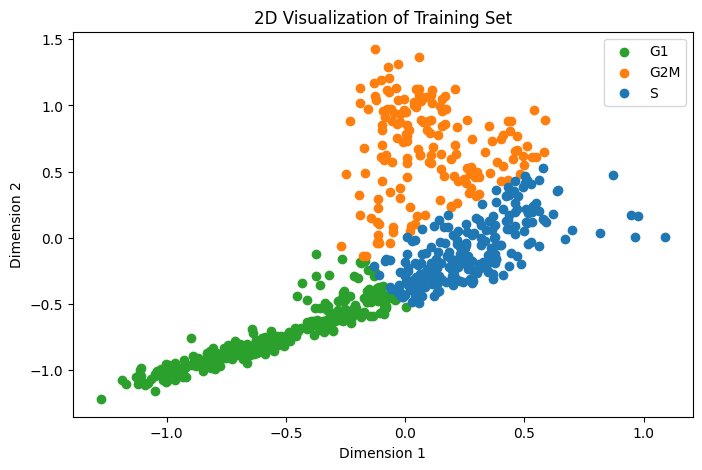

In [ ]:
df = patski_df.copy()

stage_mapping = {
    'S': [1, 0],
    'G2M': [0, 1],
    'G1': [-1, -1]
}
df = df[df['Stage'].isin(stage_mapping.keys())]
df['Target'] = df['Stage'].map(stage_mapping)

y = np.array(df['Target'].tolist())
X = df.drop(columns=['cell_id', 'p_of_s', 'Stage', 'Target']).fillna(0).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

def map_to_closest_class(predictions, targets):
    class_vectors = np.unique(targets, axis=0)
    mapped_classes = []
    for pred in predictions:
        distances = np.linalg.norm(class_vectors - pred, axis=1)
        mapped_classes.append(np.argmin(distances))
    return np.array(mapped_classes)

reduced_train = model.predict(X_train)
reduced_test = model.predict(X_test)

mapped_train = map_to_closest_class(reduced_train, y_train)
mapped_test = map_to_closest_class(reduced_test, y_train)

true_test = map_to_closest_class(y_test, y_train)
accuracy = np.mean(mapped_test == true_test)
print(f"Model Accuracy: {accuracy:.2f}")
plt.figure(figsize=(8, 5))
colors = ['#2ca02c', '#ff7f0e', '#1f77b4']
for i, label in enumerate(['G1', 'G2M', 'S']):
    plt.scatter(
        reduced_train[mapped_train == i, 0],
        reduced_train[mapped_train == i, 1],
        label=label,
        color=colors[i]
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Training Set')
plt.legend()
plt.show()

## 2D - Degree Positioning
Almost the same logic, although different approach.

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model Accuracy: 0.71


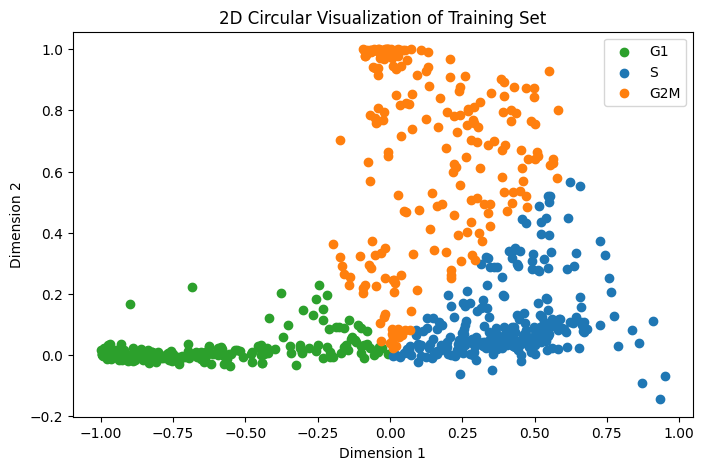

In [ ]:
df = patski_df.copy()

# Degree positioning
angle_mapping = {
    'G1': -np.pi,
    'S': 0,
    'G2M': np.pi/2
}

def map_to_circle(angle):
    return [np.cos(angle), np.sin(angle)]

df = df[df['Stage'].isin(angle_mapping.keys())]
df['Target'] = df['Stage'].map(angle_mapping).apply(map_to_circle)

y = np.array(df['Target'].tolist())
X = df.drop(columns=['cell_id', 'p_of_s', 'Stage', 'Target']).fillna(0).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='tanh')  # Reducing to [-1, 1]
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

class_vectors = np.array([map_to_circle(angle) for angle in angle_mapping.values()])

def map_to_closest_class(predictions):
    mapped_classes = []
    for pred in predictions:
        distances = np.linalg.norm(class_vectors - pred, axis=1)
        mapped_classes.append(np.argmin(distances))
    return np.array(mapped_classes)

reduced_train = model.predict(X_train)
reduced_test = model.predict(X_test)

mapped_train = map_to_closest_class(reduced_train)
mapped_test = map_to_closest_class(reduced_test)
true_test = map_to_closest_class(y_test)

accuracy = np.mean(mapped_test == true_test)
print(f"Model Accuracy: {accuracy:.2f}")

colors = ['#2ca02c', '#1f77b4', '#ff7f0e']
plt.figure(figsize=(8, 5))
for i, label in enumerate(['G1', 'S', 'G2M']):
    plt.scatter(
        reduced_train[mapped_train == i, 0],
        reduced_train[mapped_train == i, 1],
        label=label,
        color=colors[i]
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Circular Visualization of Training Set')
plt.legend()
plt.show()

## Parameters Change

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model Accuracy: 0.69


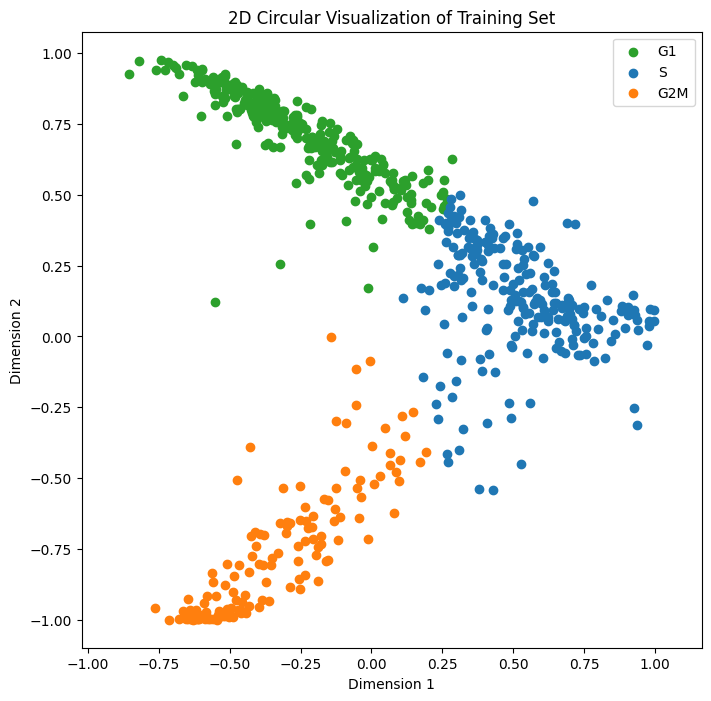

In [ ]:
df = patski_df.copy()

angle_mapping = {
    'G1': 2 * np.pi / 3,
    'S': 0,
    'G2M': 4 * np.pi / 3
}

def map_to_circle(angle):
    return [np.cos(angle), np.sin(angle)]

df = df[df['Stage'].isin(angle_mapping.keys())]
df['Target'] = df['Stage'].map(angle_mapping).apply(map_to_circle)

y = np.array(df['Target'].tolist())
X = df.drop(columns=['cell_id', 'p_of_s', 'Stage', 'Target']).fillna(0).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='tanh')
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0)

class_vectors = np.array([map_to_circle(angle) for angle in angle_mapping.values()])

def map_to_closest_class(predictions):
    mapped_classes = []
    for pred in predictions:
        distances = np.linalg.norm(class_vectors - pred, axis=1)
        mapped_classes.append(np.argmin(distances))
    return np.array(mapped_classes)

reduced_train = model.predict(X_train)
reduced_test = model.predict(X_test)

mapped_train = map_to_closest_class(reduced_train)
mapped_test = map_to_closest_class(reduced_test)
true_test = map_to_closest_class(y_test)

accuracy = np.mean(mapped_test == true_test)
print(f"Model Accuracy: {accuracy:.2f}")

colors = ['#2ca02c', '#1f77b4', '#ff7f0e']
plt.figure(figsize=(8, 8))
for i, label in enumerate(['G1', 'S', 'G2M']):
    plt.scatter(
        reduced_train[mapped_train == i, 0],
        reduced_train[mapped_train == i, 1],
        label=label,
        color=colors[i]
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Circular Visualization of Training Set')
plt.legend()
plt.axis('equal')
plt.show()

# 3D
After experimenting with a two-dimensional output, interesting patterns and the formation of a realistic pathway can be observed. This approach is then extended by assigning positions within a three-dimensional space for enhanced modeling.

The plot illustrates the positions assigned in three-dimensional space by the final CycleSort neural network for all cells, while retaining their original labels.

In [ ]:
df = patski_df.copy()

stage_mapping = {
    'S': [1, 0, 1],
    'G1': [0, 1, -1],
    'G2M': [-1, -1, 1]
}

df = df[df['Stage'].isin(stage_mapping.keys())]
df['Target'] = df['Stage'].map(stage_mapping)

y = np.array(df['Target'].tolist())
X = df.drop(columns=['cell_id', 'p_of_s', 'Stage', 'Target']).fillna(0).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

def map_to_closest_class(predictions, targets):
    class_vectors = np.unique(targets, axis=0)
    mapped_classes = []
    for pred in predictions:
        distances = np.linalg.norm(class_vectors - pred, axis=1)
        mapped_classes.append(np.argmin(distances))
    return np.array(mapped_classes)

reduced_train = model.predict(X_train)
reduced_test = model.predict(X_test)
mapped_train = map_to_closest_class(reduced_train, y_train)
mapped_test = map_to_closest_class(reduced_test, y_train)

true_test = map_to_closest_class(y_test, y_train)
accuracy = np.mean(mapped_test == true_test)
print(f"Model Accuracy: {accuracy:.2f}")

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = ['G2M', 'G1', 'S']

# Merged
fig = go.Figure()
all_data = np.vstack((reduced_train, reduced_test))
all_labels = np.concatenate((y_train, y_test))

for i, label in enumerate(labels):
    class_indices = np.all(all_labels == stage_mapping[label], axis=1)
    fig.add_trace(go.Scatter3d(
        x=all_data[class_indices, 0],
        y=all_data[class_indices, 1],
        z=all_data[class_indices, 2],
        mode='markers',
        marker=dict(size=5, color=colors[i]),
        name=label
    ))
fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    title='Interactive 3D Visualization of Combined Train and Test Set Real Classes',
    width=1100,
    height=900
)

fig.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_test, mapped_test)
print(cm)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model Accuracy: 0.73


[[24  1 13]
 [ 1 61 11]
 [ 3 17 40]]


# Vectors of Probabilities
With our model in place, we can now compute membership percentages for each state. This is achieved by calculating the distances from each cell to the assigned points and converting these distances into percentages. For this experiment, this approach performs better than the softmax function.

In [ ]:
stage_mapping = {
    'S': [0, 1, -1],
    'G1': [-1, -1, 1],
    'G2M': [1, 0, 1]
}

df = patski_df.copy()
df = df[df['Stage'].isin(stage_mapping.keys())]
df['Target'] = df['Stage'].map(stage_mapping)
cell_ids = df['cell_id'].tolist()
y = np.array(df['Target'].tolist())
X = df.drop(columns=['cell_id', 'p_of_s', 'Stage', 'Target']).fillna(0).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test, cell_ids_train, cell_ids_test = train_test_split(
    X_scaled, y, cell_ids, test_size=0.2, random_state=42
)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

class_vectors = np.unique(y_train, axis=0)
def calculate_probabilities(predictions, class_vectors):
    probabilities = []
    for pred in predictions:
        distances = np.linalg.norm(class_vectors - pred, axis=1)
        probs = 1 / (1 + distances)
        probs /= probs.sum()  # Norm 1
        probabilities.append(probs)
    return np.array(probabilities)

reduced_test = model.predict(X_test)
probabilities = calculate_probabilities(reduced_test, class_vectors)
columns = ['G1', 'S', 'G2M']
result_df = pd.DataFrame(probabilities, columns=columns)
result_df['cell_id'] = cell_ids_test
result_df = result_df[['cell_id'] + columns]

result_df

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


,cell_id,G1,S,G2M
0,SCG0092_ATCAAGACAGGCAAGC-1,0.305628,0.395945,0.298427
1,SCG0088_GCTATCCTCTATTGTC-1,0.472320,0.251164,0.276516
2,SCG0090_CTAGCTTGTGAAACAA-1,0.550374,0.208463,0.241163
3,SCG0092_AAGCGAGGTCCAAGAC-1,0.293892,0.410288,0.295820
4,SCG0091_CCTTTAGTCCGCATGA-1,0.225914,0.216630,0.557456
...,...,...,...,...
166,SCG0092_CCTATTTAGCCAGTAT-1,0.286701,0.414007,0.299292
167,SCG0090_ACCACATAGCTTGCTC-1,0.258226,0.425622,0.316152
168,SCG0088_GGCTAGTGTAAGCTCA-1,0.206311,0.572733,0.220956
169,SCG0093_AGTGAACCACTATGGC-1,0.302383,0.380097,0.317520


In [ ]:
#result_df.to_csv('mapped.csv', index=False)
patski_df[patski_df['cell_id'] == 'SCG0090_CTAGCTTGTGAAACAA-1']['Stage']

,Stage
198,G1


# Accuracy
Here are examples of other test of accuracy.

# Without Round Structure

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model Accuracy: 0.73


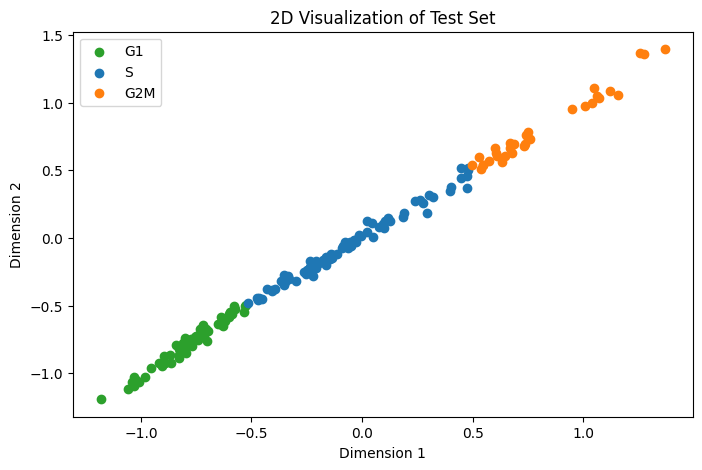

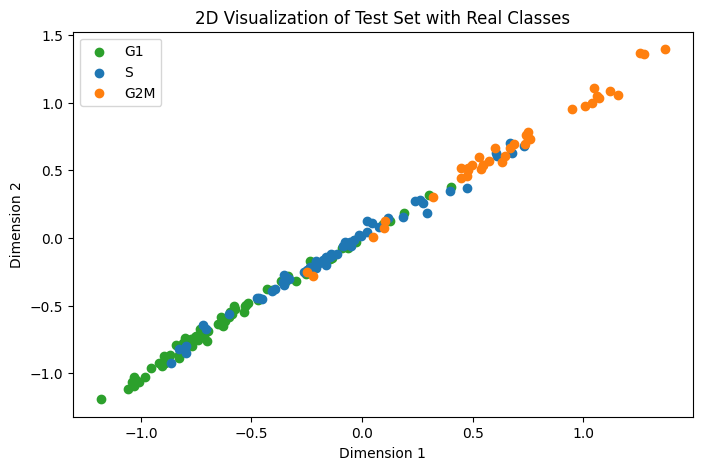

In [ ]:
df = patski_df.copy()

stage_mapping = {
    'S': [0, 0],
    'G2M': [1, 1],
    'G1': [-1, -1]
}
df = df[df['Stage'].isin(stage_mapping.keys())]
df['Target'] = df['Stage'].map(stage_mapping)

y = np.array(df['Target'].tolist())
X = df.drop(columns=['cell_id', 'p_of_s', 'Stage', 'Target']).fillna(0).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

def map_to_closest_class(predictions, targets):
    class_vectors = np.unique(targets, axis=0)
    mapped_classes = []
    for pred in predictions:
        distances = np.linalg.norm(class_vectors - pred, axis=1)
        mapped_classes.append(np.argmin(distances))
    return np.array(mapped_classes)

reduced_train = model.predict(X_train)
reduced_test = model.predict(X_test)

mapped_train = map_to_closest_class(reduced_train, y_train)
mapped_test = map_to_closest_class(reduced_test, y_train)

true_test = map_to_closest_class(y_test, y_train)
accuracy = np.mean(mapped_test == true_test)
print(f"Model Accuracy: {accuracy:.2f}")


colors = ['#2ca02c', '#1f77b4', '#ff7f0e']

plt.figure(figsize=(8, 5))
for i, label in enumerate(['G1', 'S', 'G2M']):
    plt.scatter(
        reduced_test[mapped_test == i, 0],
        reduced_test[mapped_test == i, 1],
        label=label,
        color=colors[i]
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Test Set')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, label in enumerate(['G1', 'S', 'G2M']):
    class_indices = np.all(y_test == stage_mapping[label], axis=1)
    plt.scatter(
        reduced_test[class_indices, 0],
        reduced_test[class_indices, 1],
        label=label,
        color=colors[i]
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Test Set with Real Classes')
plt.legend()
plt.show()

## Incorrect Order (Not in scheme of G1 - S - G2)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model Accuracy: 0.44


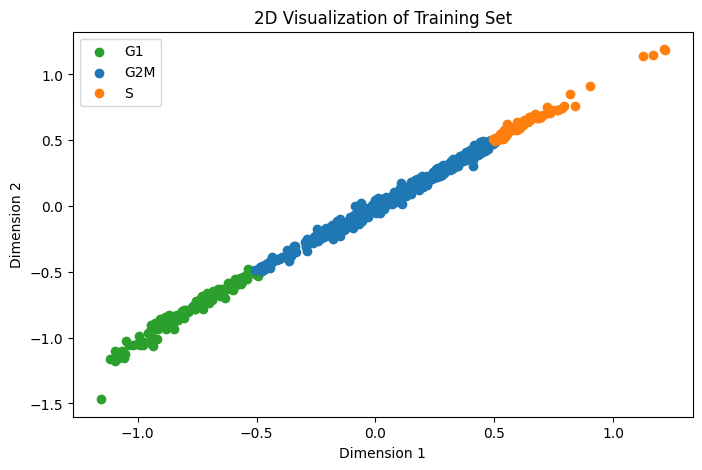

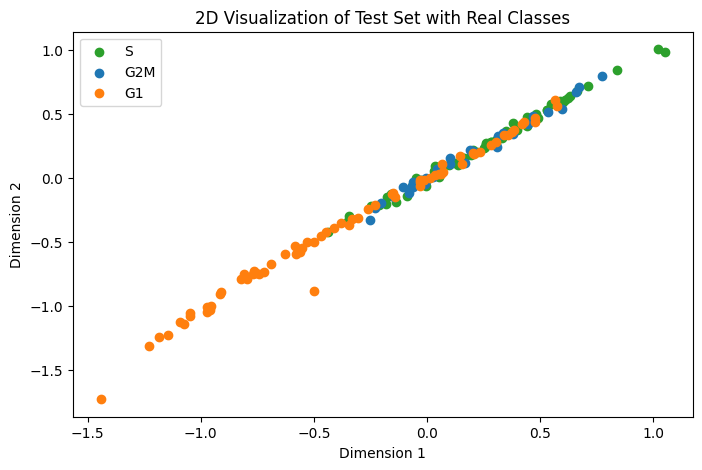

In [ ]:
df = patski_df.copy()

stage_mapping = {
    'S': [1, 1],
    'G2M': [0, 0],
    'G1': [-1, -1]
}
df = df[df['Stage'].isin(stage_mapping.keys())]
df['Target'] = df['Stage'].map(stage_mapping)

y = np.array(df['Target'].tolist())
X = df.drop(columns=['cell_id', 'p_of_s', 'Stage', 'Target']).fillna(0).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

def map_to_closest_class(predictions, targets):
    class_vectors = np.unique(targets, axis=0)
    mapped_classes = []
    for pred in predictions:
        distances = np.linalg.norm(class_vectors - pred, axis=1)
        mapped_classes.append(np.argmin(distances))
    return np.array(mapped_classes)

reduced_train = model.predict(X_train)
reduced_test = model.predict(X_test)

mapped_train = map_to_closest_class(reduced_train, y_train)
mapped_test = map_to_closest_class(reduced_test, y_train)

true_test = map_to_closest_class(y_test, y_train)
accuracy = np.mean(mapped_test == true_test)
print(f"Model Accuracy: {accuracy:.2f}")
colors = ['#2ca02c', '#1f77b4', '#ff7f0e']

plt.figure(figsize=(8, 5))
for i, label in enumerate(['G1', 'G2M', 'S']):
    plt.scatter(
        reduced_train[mapped_train == i, 0],
        reduced_train[mapped_train == i, 1],
        label=label,
        color=colors[i]
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Training Set')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, label in enumerate(['S', 'G2M', 'G1']):
    class_indices = np.all(y_test == stage_mapping[label], axis=1)
    plt.scatter(
        reduced_test[class_indices, 0],
        reduced_test[class_indices, 1],
        label=label,
        color=colors[i]
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Test Set with Real Classes')
plt.legend()
plt.show()


## 3D Incorrect Order

In [ ]:
df = patski_df.copy()

stage_mapping = {
    'S': [0, 1, -1],
    'G1': [-1, -1, 1],
    'G2M': [1, 0, 1]
}


df = df[df['Stage'].isin(stage_mapping.keys())]
df['Target'] = df['Stage'].map(stage_mapping)

y = np.array(df['Target'].tolist())
X = df.drop(columns=['cell_id', 'p_of_s', 'Stage', 'Target']).fillna(0).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

def map_to_closest_class(predictions, targets):
    class_vectors = np.unique(targets, axis=0)
    mapped_classes = []
    for pred in predictions:
        distances = np.linalg.norm(class_vectors - pred, axis=1)
        mapped_classes.append(np.argmin(distances))
    return np.array(mapped_classes)

reduced_train = model.predict(X_train)
reduced_test = model.predict(X_test)
mapped_train = map_to_closest_class(reduced_train, y_train)
mapped_test = map_to_closest_class(reduced_test, y_train)

true_test = map_to_closest_class(y_test, y_train)
accuracy = np.mean(mapped_test == true_test)
print(f"Model Accuracy: {accuracy:.2f}")

# Real
colors = ['#1f77b4', '#2ca02c', '#ff7f0e']
fig = go.Figure()

all_data = np.vstack((reduced_train, reduced_test))
all_labels = np.concatenate((y_train, y_test))

for i, label in enumerate(labels):
    class_indices = np.all(y_test == stage_mapping[label], axis=1)
    fig.add_trace(go.Scatter3d(
        x=reduced_test[class_indices, 0],
        y=reduced_test[class_indices, 1],
        z=reduced_test[class_indices, 2],
        mode='markers',
        marker=dict(size=5, color=colors[i]),
        name=label
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    title='Interactive 3D Visualization of Test Set Real Classes'
)

fig.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model Accuracy: 0.73


# Additional Analysis

Accuracy: 0.6491228070175439
Classification Report:
               precision    recall  f1-score   support

          G1       0.74      0.64      0.69        75
         G2M       0.77      0.71      0.74        38
           S       0.51      0.62      0.56        58

    accuracy                           0.65       171
   macro avg       0.67      0.66      0.66       171
weighted avg       0.67      0.65      0.65       171

Confusion Matrix:
 [[48  1 26]
 [ 2 27  9]
 [15  7 36]]

Feature Importances:
                Feature  Importance
10       pofs_intercept    0.080790
34      tad_n_tads_mean    0.057199
8         mcm_far_ratio    0.055870
36     tad_density_mean    0.051181
35    tad_mean_bin_size    0.048427
7         mcm_mid_ratio    0.041474
9            pofs_slope    0.036164
6        mcm_near_ratio    0.035977
0               f_trans    0.034409
33           chrX_value    0.030632
15          chr10_value    0.028666
26           chr3_value    0.028354
4                   

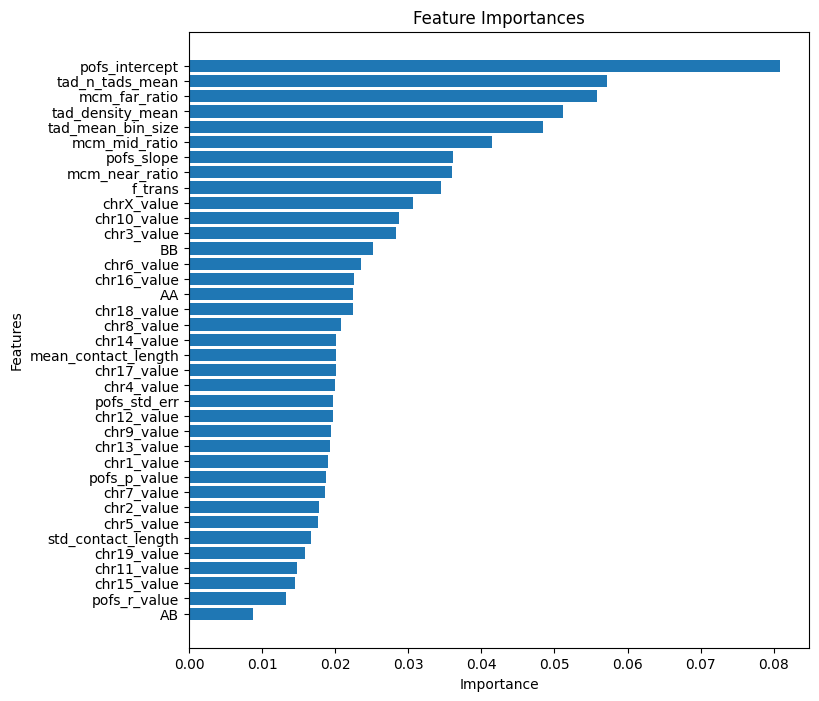

In [ ]:
from sklearn.metrics import confusion_matrix

df = patski_df.copy()
df = df.drop(columns=["cell_id", "p_of_s"])

imputer = SimpleImputer(strategy="mean")
df.iloc[:, :-1] = imputer.fit_transform(df.iloc[:, :-1])

y = df["Stage"]
X = df.drop(columns=["Stage"])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importances:")
print(feature_importances)
plt.figure(figsize=(8, 8))
plt.barh(feature_importances["Feature"], feature_importances["Importance"])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
df = patski_df.copy()

stage_mapping = {
    'S': [1, 0, 1], #[1, 0, 1]
    'G1': [1, 0, 1],
    'G2M': [-1, -1, 1]
}

df = df[df['Stage'].isin(stage_mapping.keys())]
df['Target'] = df['Stage'].map(stage_mapping)

y = np.array(df['Target'].tolist())
X = df.drop(columns=['cell_id', 'p_of_s', 'Stage', 'Target']).fillna(0).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

def map_to_closest_class(predictions, targets):
    class_vectors = np.unique(targets, axis=0)
    mapped_classes = []
    for pred in predictions:
        distances = np.linalg.norm(class_vectors - pred, axis=1)
        mapped_classes.append(np.argmin(distances))
    return np.array(mapped_classes)

reduced_train = model.predict(X_train)
reduced_test = model.predict(X_test)
mapped_train = map_to_closest_class(reduced_train, y_train)
mapped_test = map_to_closest_class(reduced_test, y_train)

true_test = map_to_closest_class(y_test, y_train)
accuracy = np.mean(mapped_test == true_test)
print(f"Model Accuracy: {accuracy:.2f}")

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = ['G2M', 'G1', 'S']


# Merged
fig = go.Figure()
all_data = np.vstack((reduced_train, reduced_test))
all_labels = np.concatenate((y_train, y_test))

for i, label in enumerate(labels):
    class_indices = np.all(all_labels == stage_mapping[label], axis=1)
    fig.add_trace(go.Scatter3d(
        x=all_data[class_indices, 0],
        y=all_data[class_indices, 1],
        z=all_data[class_indices, 2],
        mode='markers',
        marker=dict(size=5, color=colors[i]),
        name=label
    ))
fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    title='Interactive 3D Visualization of Combined Train and Test Set Real Classes',
    width=1100,
    height=900
)

fig.show()

from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, reduced_test)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_test, mapped_test)
print(cm)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model Accuracy: 0.88


Mean Squared Error (MSE): 0.1273
[[ 21  17]
 [  3 130]]
